In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
table_names = Base.classes.keys()
print("Reflected tables:", table_names)

Reflected tables: ['measurement', 'station']


In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [17]:
# Find the most recent date in the data set.
inspector = inspect(engine) #Bringing the inspector to check the table header
measurement_name=Measurement.__table__.name 

columns = inspector.get_columns(measurement_name) #
column_names=[column['name'] for column in columns]
print (column_names)
recent = session.query(func.max(Measurement.date)).scalar()
recent_date = datetime.strptime(recent, '%Y-%m-%d')

['id', 'station', 'date', 'prcp', 'tobs']


Most recent date in the data set is 2017-08-23
A year from that date is 2016-08-23 00:00:00 


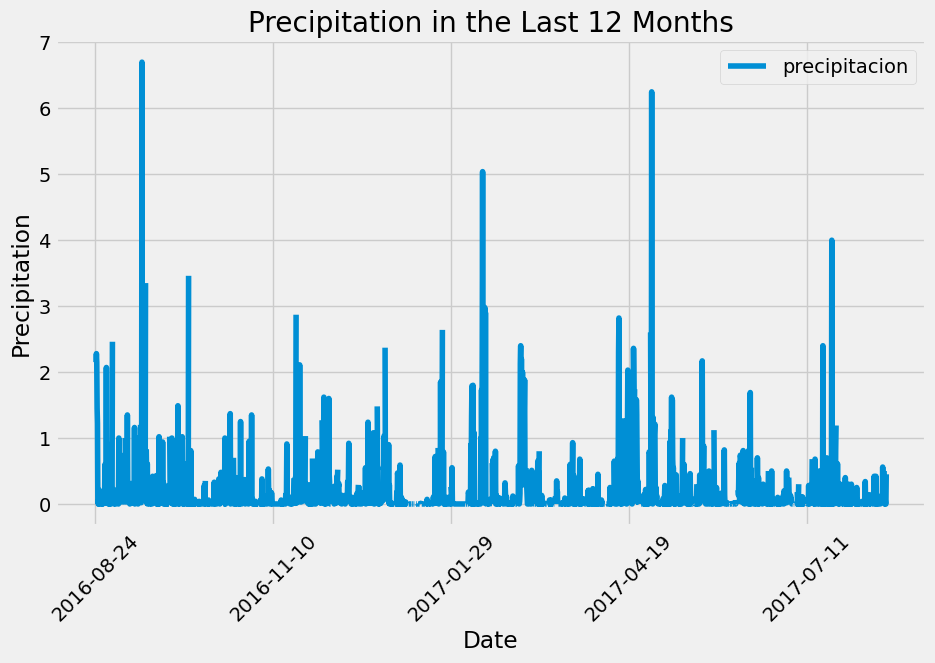

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent = session.query(func.max(Measurement.date)).scalar()
recent_date = datetime.strptime(recent, '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
year_before= recent_date - timedelta(days=365)
print (f"Most recent date in the data set is {recent}")
print(f"A year from that date is {year_before} ")
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.station, Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= year_before).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
Measure_df = pd.DataFrame(results, columns=['satiton', 'date','precipitacion'])
# Sort the dataframe by date
Measure_df=Measure_df.sort_values('date')
# Use Pandas Plotting with Matplotlib to plot the data

Measure_df.set_index('date', inplace=True)
Measure_df.plot(figsize=(10, 6), title='Precipitation in the Last 12 Months', rot=45)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
Measure_df.describe()

,precipitacion
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [32]:
# Design a query to calculate the total number of stations in the dataset
inspector = inspect(engine) #Bringing the inspector to check the table header
stations=Station.__table__.name 
columns_stations = inspector.get_columns(stations)
column_names_stations =[column['name'] for column in columns]
print (column_names_stations)

station_number= session.query(func.count(Station.id)).scalar()
print(station_number)

['id', 'station', 'date', 'prcp', 'tobs']
9


In [54]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = (
    session.query(Station.station, func.count(Measurement.id).label('count'))
    .join(Measurement, Station.station == Measurement.station)
    .group_by(Station.station)
    .order_by(func.count(Measurement.id).desc())
    .all()
)
most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [71]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_one = most_active_stations[0][0]

station_one_data =session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == station_one)


print(f"Lowest Temperature: {station_one_data[0][0]}")
print(f"Highest Temperature: {station_one_data[0][1]}")
print(f"Average Temperature: {station_one_data[0][2]}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


<function matplotlib.pyplot.show(close=None, block=None)>

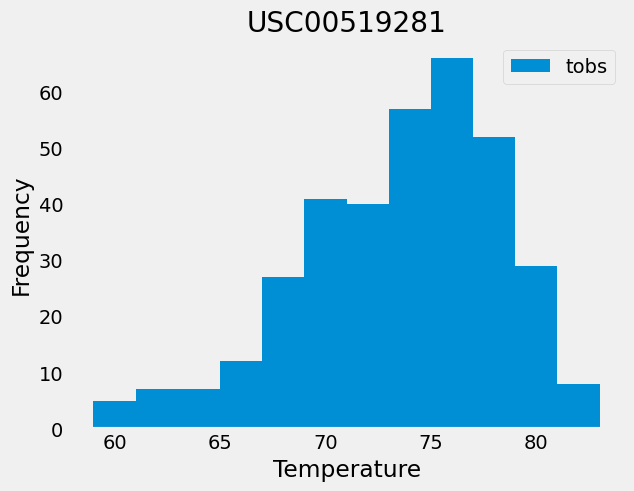

In [74]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observe = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == station_one).\
                filter(Measurement.date >= year_before).all()

temp_df = pd.DataFrame(temp_observe)

temp_df.plot.hist(by='station', bins=12)
plt.xlabel("Temperature")
plt.grid()
plt.show

# Close Session

In [16]:
# Close Session
session.close()